In [3]:
from langchain_core.messages.chat import ChatMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import load_prompt 
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from utils.utils import set_model,setstate
import tempfile
import os 
from utils.utils import *

from langchain.output_parsers import PandasDataFrameOutputParser 



In [4]:
load_dotenv()




True

# 파서를 통해 우리가 지정한 형식 , 스키마 형태로 데이터를 받아올 수 있다. 이 점이 좋은 건 내가 번역기 만들었을 때 무슨 번역이 필요하신가요 같은 쓸데없는 주석땜에 고생한거 해결해줄 수 있을 것 같다. 

In [11]:
blood_born = '''
[Entry Log: August 2, 1999]
***The hunter's first Encounter with the Doll***
The doll:  Welcome home, good hunter, what is it your desire?
인형: 어서오세요, 사냥꾼님, 무엇을 소망하시나요?
The Hunter remains silent, simply watching her.
그는 아무 말도 하지 않고, 그저 그녀를 바라보았다. 
The doll: May you find your worth in the waking world
인형: 깨어난 세상에서 가치를 찾으시길
And with that, The Hunter gives a silent nod, then vanishes from his dream.
사냥꾼은 말없이 고개를 끄덕이고는, 그의 꿈에서 자취를 감추었다.
 '''

In [12]:
from itertools import chain
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    "다음의 대사 중 중요한 내용을 추출해 주세요.\n\n{blood_born}"
)

llm = set_model()

chain = prompt | llm

answer = chain.stream({"blood_born": blood_born})
temp = ''
for token in answer :
    print(token.content,end = '',flush=True)

중요한 내용 요약:

1. 날짜: 1999년 8월 2일
2. 사건: 사냥꾼과 인형(드롤) 간의 첫 만남
3. 인형의 인사: "환영합니다, 사냥꾼님, 무엇을 소망하시나요?"
4. 사냥꾼은 침묵하며 인형을 관찰함
5. 인형의 희망 메시지: "깨어난 세상에서 가치를 찾으시길"
6. 사냥꾼은 말없이 고개를 끄덕이고 꿈에서 사라짐

이 내용은 사냥꾼과 인형의 첫 만남과 인형이 전하는 메시지, 그리고 사냥꾼의 침묵과 떠남을 보여줍니다.

In [63]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
class bloodSummary(BaseModel):
    person: str = Field(description="대사를 한 사람")
    sex : str = Field(description="대사를 한 사람의 성별")
    subject: str = Field(description="상황의 제목")
    summary: str = Field(description="상황을 요약한 내용")
    date: str = Field(description="현재 상황 속 날짜")


# PydanticOutputParser 생성
parser = PydanticOutputParser(pydantic_object=bloodSummary)

## 이런것처럼, 실제로 걍 프롬프트에 적어주기만 해도 되긴 함 ㅇㅇ

In [15]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"person": {"description": "대사를 한 사람", "title": "Person", "type": "string"}, "sex": {"description": "대사를 한 사람의 성별", "title": "Sex", "type": "string"}, "subject": {"description": "상황의 제목", "title": "Subject", "type": "string"}, "summary": {"description": "상황을 요약한 내용", "title": "Summary", "type": "string"}, "date": {"description": "현재 상황 속 날짜", "title": "Date", "type": "string"}}, "required": ["person", "sex", "subject", "summary", "date"]}
```


In [16]:
prompts = PromptTemplate.from_template('''
    당신은 친절한 도우미입니다. 다음 질문에 한국어로 답변해주세요 
    Qustion:
    {question}
    blood_borns:
    {blood_born}
                                       
    format:
    {format}
                                       
                                       
''')

prompt = prompts.partial(format = parser.get_format_instructions())


In [17]:
chain = prompt | llm 

In [30]:
response = chain.stream({'question':'대사 중 주요한 내용은 무엇이었나요?', 'blood_born':blood_born})
temp  = ''
for token in response:
    print(token.content , end = '' ,flush=True )
    temp += token.content

{"person": "인형", "sex": "여성", "subject": "대사 중 주요 내용", "summary": "인형이 사냥꾼에게 환영하며 소망을 묻고, 깨어난 세상에서 가치를 찾기를 바라는 메시지를 전달하는 대화입니다. 사냥꾼은 말을 하지 않고 그녀를 바라보다가 조용히 고개를 끄덕이고 꿈에서 사라집니다.", "date": "1999년 8월 2일"}

## 이렇게 쓰거나, 아님 걍 인보크해서 전부 불러오거나.

In [53]:

# 현재 temp에 있는 JSON 문자열을 딕셔너리로 변환하는 방법
import json

print("현재 temp 변수 내용:")
print(temp)

# JSON 문자열을 딕셔너리로 변환
try:
    temp_dict = json.loads(temp)
    print("\nJSON 파싱 성공!")
    print("딕셔너리:", temp_dict)
    print("타입:", type(temp_dict))
    
    # 각 필드 접근
    print(f"\n대사한 사람: {temp_dict['person']}")
    print(f"성별: {temp_dict['sex']}")
    print(f"제목: {temp_dict['subject']}")
    print(f"요약: {temp_dict['summary']}")
    print(f"날짜: {temp_dict['date']}")
    
except json.JSONDecodeError as e:
    print(f"JSON 파싱 실패: {e}")
    print("문자열이 완전한 JSON이 아닐 수 있습니다.")

현재 temp 변수 내용:
{"person": "인형", "sex": "여성", "subject": "대사 중 주요 내용", "summary": "인형이 사냥꾼에게 환영하며 소망을 묻고, 깨어난 세상에서 가치를 찾기를 바라는 메시지를 전달하는 대화입니다. 사냥꾼은 말을 하지 않고 그녀를 바라보다가 조용히 고개를 끄덕이고 꿈에서 사라집니다.", "date": "1999년 8월 2일"}

JSON 파싱 성공!
딕셔너리: {'person': '인형', 'sex': '여성', 'subject': '대사 중 주요 내용', 'summary': '인형이 사냥꾼에게 환영하며 소망을 묻고, 깨어난 세상에서 가치를 찾기를 바라는 메시지를 전달하는 대화입니다. 사냥꾼은 말을 하지 않고 그녀를 바라보다가 조용히 고개를 끄덕이고 꿈에서 사라집니다.', 'date': '1999년 8월 2일'}
타입: <class 'dict'>

대사한 사람: 인형
성별: 여성
제목: 대사 중 주요 내용
요약: 인형이 사냥꾼에게 환영하며 소망을 묻고, 깨어난 세상에서 가치를 찾기를 바라는 메시지를 전달하는 대화입니다. 사냥꾼은 말을 하지 않고 그녀를 바라보다가 조용히 고개를 끄덕이고 꿈에서 사라집니다.
날짜: 1999년 8월 2일


## 가 아니라 이렇게 파서를 쓰면 알아서 객체로 바꿔줌 

In [55]:
structured_output = parser.parse(temp)

In [58]:
structured_output.person


'인형'

## 그니까 따로 쓰지말고 걍 체인에 엮어버리는 거

In [59]:

chain = prompt | llm | parser 

In [64]:
response = chain.invoke({'question':'대사 중 주요한 내용은 무엇이었나요?', 'blood_born':blood_born})
    

In [65]:
response.person

'인형과 사냥꾼'

## 혹은 모델을 선언할 때 붙여버릴 수도 있다.


In [67]:
llm_structed = llm = ChatOpenAI(
        temperature= 0.2,
        model= 'gpt-4.1-nano-2025-04-14',
    ).with_structured_output(bloodSummary)
# 얘는 스트림 기능을 지원하진 않음 

In [68]:
answer = llm_structed.invoke(blood_born)


In [69]:
answer.person

'사냥꾼'

In [70]:
answer.sex

'알 수 없음'

## commaseparetedparseroutputparser

In [71]:
from langchain_core.output_parsers import CommaSeparatedListOutputParser

cparser = CommaSeparatedListOutputParser()

format_instruc = cparser.get_format_instructions()

## 얘도 결국 지침일 뿐인데 라이브러리화 시켜둔거 

In [72]:
print(format_instruc)

Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`


In [77]:
prompt2 = PromptTemplate(
    template='list five {subject}. \n {format_instruc}',
    input_variables= ['subject'], # 입력 이걸로받고 
    partial_variables= {'format_instruc':format_instruc}, 
    #채워질 변수는 없다면 얘로 넣어두고, 위에 프린트한대로 들어가겠음 따로 변수를 넣지 않는다면 
)

model = set_model()

chain2 = prompt2 | model | cparser
# 엮기만했지 아직 변수를 넣진 않고 순서대로 -> -> 넘김 


In [78]:
answer = chain2.invoke({'subject':'백일몽의 청사진 속 등장인물의 시대적 배경'})

## 뭔 이상한 소리를 적어뒀지만 여튼 리스트 형태로 잘 반환됐음

In [79]:
answer 

['조선시대', '현대 대한민국', '일제강점기', '1980년대', '미래 도시']

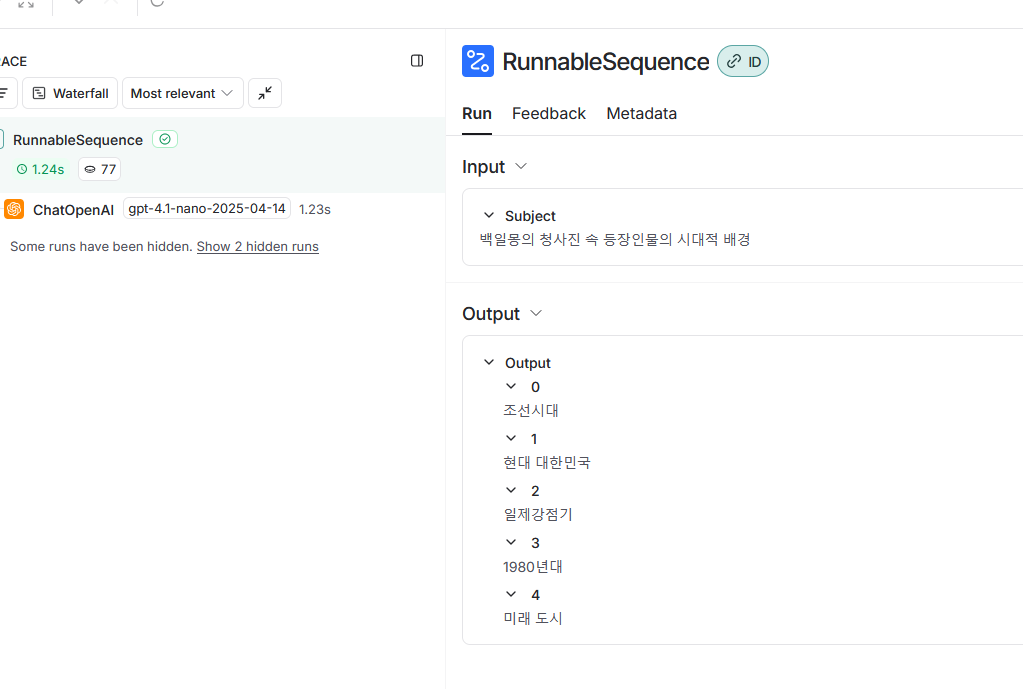

In [82]:
from IPython.display import Image
Image(r"C:\Users\roaco\OneDrive\사진\스크린샷\스크린샷 2025-06-16 135210.png")

## 원칙상 stream 기능을 쓸거라면 아웃풋 파서를 안쓰는게 맞긴하다!

In [83]:
answer = chain2.stream({'subject':'백일몽의 청사진 속 등장인물의 시대적 배경'})

for token in answer:
    print(token, end = '' , flush= True)
    

['조선시대']['현대 대한민국']['일제강점기']['1980년대']['미래 도시']

## gpt 말고 로컬을 쓰는 경우도 존재하므로 dict 형식으로 리턴하는 다른 얘도 있음 , structured 아웃풋파서 pydantic/json이 더 잘되는데 이게 좀 모자란 모델 쓸 때는 이게 낫다라는 얘기임

In [5]:


from langchain.output_parsers import ResponseSchema, StructuredOutputParser

In [86]:
responese_schemas = [
    ResponseSchema(name='answer',description='사용자 질문에 대한 답변'),
    ResponseSchema(
        name = 'source',
        description= '사용자 질문에 답하기 위해 사용한 출처, 웹사이트 주소여야 합니다.'

    ),

]

oparser = StructuredOutputParser.from_response_schemas(responese_schemas)


In [87]:
oparser

StructuredOutputParser(response_schemas=[ResponseSchema(name='answer', description='사용자 질문에 대한 답변', type='string'), ResponseSchema(name='source', description='사용자 질문에 답하기 위해 사용한 출처, 웹사이트 주소여야 합니다.', type='string')])

In [92]:
fromat_instructed = oparser.get_format_instructions()

prompt3 = PromptTemplate(
    template='유저의 질문에 최선을 다해 답하세요 \n{fromat_instructed} \n {question}',
    input_variables= ['question'], # 입력변수는 퀘스천 
    partial_variables={'fromat_instructed':fromat_instructed},
    # 미리 채워넣을거 이거 따로 입력 안하면 이걸로 채워짐 
)

chain3 = prompt3 | model | oparser 


In [93]:
answer = chain3.invoke({'question':'6월16일이 생인인 유명인은 누가 있나요?'})
answer 

{'answer': '6월 16일에 생일인 유명인으로는 미국의 배우 조지 클루니(George Clooney)가 있습니다.',
 'source': 'https://en.wikipedia.org/wiki/June_16'}

In [94]:
print(prompt3)

input_variables=['question'] input_types={} partial_variables={'fromat_instructed': 'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"answer": string  // 사용자 질문에 대한 답변\n\t"source": string  // 사용자 질문에 답하기 위해 사용한 출처, 웹사이트 주소여야 합니다.\n}\n```'} template='유저의 질문에 최선을 다해 답하세요 \n{fromat_instructed} \n {question}'


In [95]:
print(oparser)

response_schemas=[ResponseSchema(name='answer', description='사용자 질문에 대한 답변', type='string'), ResponseSchema(name='source', description='사용자 질문에 답하기 위해 사용한 출처, 웹사이트 주소여야 합니다.', type='string')]


In [97]:
answer['source']

'https://en.wikipedia.org/wiki/June_16'

## json 아웃풋 파서는 내가 원하는 json 스키마를 지정할 수 있음, 답변을 json형태로 받게할 수 있다~ 정도로 요약 , 사용자가 원하는 형태의 json 되기 위해서면 좀 모델의 용량이 커야함 

### 구조 정의하기 앞선 거랑 뭐 똑같음 

In [116]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel,Field 

class mapleSummary(BaseModel):
    person: str = Field(description="대상 캐릭터의 이름")
    sex : str = Field(description="대상 캐릭터의 성별")
    job : str = Field(description="대상 캐릭터의 직업")
    lavel :str = Field(description="대상 캐릭터의 레벨")
    from_maple_gg :str = Field(description="대상 캐릭터의 정보 출처 예시 : https://maple.gg/")



In [117]:
question = '엘리시움 서버:ICT공학 캐릭터의 정보를 알려주세요'
oparser = JsonOutputParser(pydantic_object=mapleSummary)
 

In [118]:
print(oparser)

pydantic_object=<class '__main__.mapleSummary'>


In [119]:
prompt_maple = PromptTemplate(
    template= '''당신은 메이플스토리 출시부터 지금까지 데이터베이스를 구축한 사람입니다. 질문에 답해주세요 
    또한 반드시 출처를 포함해주세요
    question:
    {question}

    format:
    {format}     
     ''' 
)

pt_maple = prompt_maple.partial(format=oparser.get_format_instructions())


In [120]:
pt_maple

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={'format': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"person": {"title": "Person", "description": "대상 캐릭터의 이름", "type": "string"}, "sex": {"title": "Sex", "description": "대상 캐릭터의 성별", "type": "string"}, "job": {"title": "Job", "description": "대상 캐릭터의 직업", "type": "string"}, "lavel": {"title": "Lavel", "description": "대상 캐릭터의 레벨", "type": "string"}, "from_maple_gg": {"title": "From Maple Gg", "description": "대상 캐릭터의 정보 출처 예시 : https://maple.gg/", "type": "string"}}, "required": ["pers

In [125]:
model = ChatOpenAI(model='gpt-4.1-2025-04-14')
chain_maple = pt_maple | model | oparser 


In [126]:
response = chain_maple.invoke({'question':question}) 
response

{'person': 'ICT공학',
 'sex': '남자',
 'job': '아델',
 'lavel': '282',
 'from_maple_gg': 'https://maple.gg/character/ICT%EA%B3%B5%ED%95%99'}

In [109]:
type(response)

dict

In [111]:
response['person']


'ICT공학'

### 판다스 데이터 프레임 아웃풋 파서라는 것도 있음 


In [127]:
import pprint
from typing import Any, Dict 

import pandas as pd 

from langchain.output_parsers import PandasDataFrameOutputParser 



In [128]:
model = set_model()

In [129]:
def format_parser_op(parser_output: Dict[str,Any]) -> None:
    # 파서 출력 키들을 순회함 
    for key in parser_output.keys():
        parser_output[key] = parser_output[key].to_dict()

    return pprint.PrettyPrinter(width=4, compact=True).pprint(parser_output)


In [131]:
import pandas as pd 

df = pd.read_csv(r'C:\Users\roaco\Desktop\프로젝트들 정리하기\github\titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [133]:
oparser = PandasDataFrameOutputParser(dataframe=df)

print(oparser.get_format_instructions())


The output should be formatted as a string as the operation, followed by a colon, followed by the column or row to be queried on, followed by optional array parameters.
1. The column names are limited to the possible columns below.
2. Arrays must either be a comma-separated list of numbers formatted as [1,3,5], or it must be in range of numbers formatted as [0..4].
3. Remember that arrays are optional and not necessarily required.
4. If the column is not in the possible columns or the operation is not a valid Pandas DataFrame operation, return why it is invalid as a sentence starting with either "Invalid column" or "Invalid operation".

As an example, for the formats:
1. String "column:num_legs" is a well-formatted instance which gets the column num_legs, where num_legs is a possible column.
2. String "row:1" is a well-formatted instance which gets row 1.
3. String "column:num_legs[1,2]" is a well-formatted instance which gets the column num_legs for rows 1 and 2, where num_legs is a p

### 규칙 겁나 많음 

In [145]:
prompt_tatanic = PromptTemplate(
    template='''당신은 타이타닉 참사의 모든 것을 알고 있는 역사학자 입니다. 질문에 답해주세요
    qeustion:
    {question}
    
    format:
    {format}
    '''
    ,
    input_variables= ['question']
)

pt_tanic = prompt_tatanic.partial(format=oparser.get_format_instructions())
pt_tanic

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={'format': 'The output should be formatted as a string as the operation, followed by a colon, followed by the column or row to be queried on, followed by optional array parameters.\n1. The column names are limited to the possible columns below.\n2. Arrays must either be a comma-separated list of numbers formatted as [1,3,5], or it must be in range of numbers formatted as [0..4].\n3. Remember that arrays are optional and not necessarily required.\n4. If the column is not in the possible columns or the operation is not a valid Pandas DataFrame operation, return why it is invalid as a sentence starting with either "Invalid column" or "Invalid operation".\n\nAs an example, for the formats:\n1. String "column:num_legs" is a well-formatted instance which gets the column num_legs, where num_legs is a possible column.\n2. String "row:1" is a well-formatted instance which gets row 1.\n3. String "column:num_legs[1,2]"

In [140]:
model = ChatOpenAI(model = 'gpt-4.1-2025-04-14')
chain_tanic = pt_tanic | model | oparser 



In [146]:
response = chain_tanic.invoke({'question':'age 컬럼을 조회해주세요'})
format_parser_op(response)

{'Age': {0: 22.0,
         1: 38.0,
         2: 26.0,
         3: 35.0,
         4: 35.0,
         5: nan,
         6: 54.0,
         7: 2.0,
         8: 27.0,
         9: 14.0,
         10: 4.0,
         11: 58.0,
         12: 20.0,
         13: 39.0,
         14: 14.0,
         15: 55.0,
         16: 2.0,
         17: nan,
         18: 31.0,
         19: nan}}


### 모든 정보를 실제로 llm이 조회하는 게 아니라 query문을 날려주는 거임 

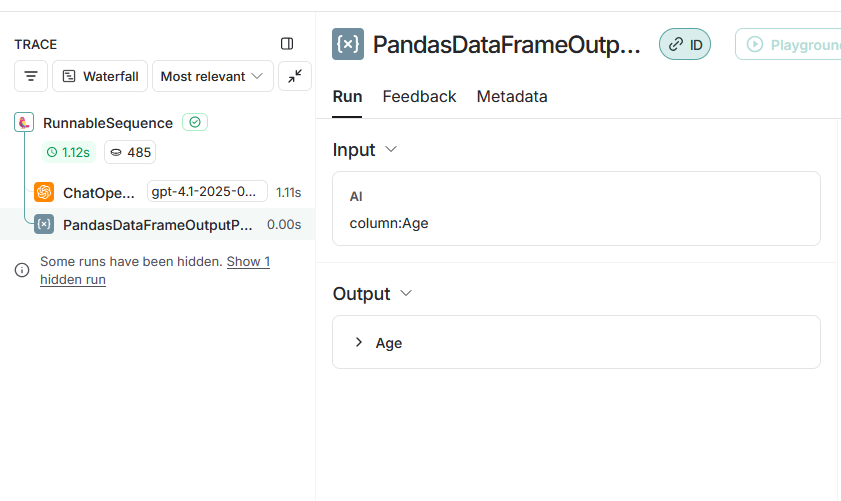

In [148]:
Image(r"C:\Users\roaco\OneDrive\사진\스크린샷\스크린샷 2025-06-16 152714.png")

### datetime 아웃풋 파서 

In [149]:


from langchain.output_parsers import DatetimeOutputParser

In [150]:
oparser = DatetimeOutputParser()
oparser.format='%Y-%m-%d'


In [152]:
prompt_date = PromptTemplate(
    template='''질문에 답해주세요 
    
    #Format instructions:
    {format_instructions}
    question:
    {question}

    ''',
    input_variables=['question'],
    partial_variables={'format_instructions' : oparser.get_format_instructions()}

)

prompt_date

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={'format_instructions': "Write a datetime string that matches the following pattern: '%Y-%m-%d'.\n\nExamples: 1447-05-26, 1843-10-03, 1307-03-31\n\nReturn ONLY this string, no other words!"}, template='질문에 답해주세요 \n\n    #Format instructions:\n    {format_instructions}\n    question:\n    {question}\n\n    ')

In [153]:
chain_date = prompt_date | model | oparser



In [154]:
answer = chain_date.invoke({'question':'오늘 날짜는 몇일인가요?'})


### 이건 포멧 찾아보면서 %어쩌구들 알아서 조정해야함 

In [155]:
answer 

datetime.datetime(2023, 12, 31, 0, 0)

### enum 아웃풋 파서 언어 모델 출력을 미리 열거형으로 파싱하는 것 

In [170]:
from enum import Enum 
from langchain.output_parsers import EnumOutputParser
class colors(Enum):
    red = '빨간색'
    green = '초록색'
    blue = '파란색'

### value가 아무리 복잡하더라도, .red같이 간략하게 호출하고 싶을 때 유용한편 

In [171]:
colors.blue

<colors.blue: '파란색'>

In [172]:
oparser = EnumOutputParser(enum=colors)
oparser

EnumOutputParser(enum=<enum 'colors'>)

### 이게 프롬프트의 입력으로 들어감, 그러므로 복잡하게 좀 적어도 됨 value는 

In [181]:
oparser.get_format_instructions()

'Select one of the following options: 빨간색, 초록색, 파란색'

In [185]:
prompt_enums = PromptTemplate(
    template='''다음의 물체는 어떠한 색일까요? 
    instructions에 맞게 대답해주세요 
    object:
    {object}
    instructions:
    {instrctions}''',
    input_variables= ['object'],
).partial(instrctions = oparser.get_format_instructions())

prompt_enums

PromptTemplate(input_variables=['object'], input_types={}, partial_variables={'instrctions': 'Select one of the following options: 빨간색, 초록색, 파란색'}, template='다음의 물체는 어떠한 색일까요? \n    instructions에 맞게 대답해주세요 \n    object:\n    {object}\n    instructions:\n    {instrctions}')

In [186]:
model = set_model()
chain_enum = prompt_enums | model | oparser 

chain_enum

PromptTemplate(input_variables=['object'], input_types={}, partial_variables={'instrctions': 'Select one of the following options: 빨간색, 초록색, 파란색'}, template='다음의 물체는 어떠한 색일까요? \n    instructions에 맞게 대답해주세요 \n    object:\n    {object}\n    instructions:\n    {instrctions}')
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002304F7515E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000230503E0E30>, root_client=<openai.OpenAI object at 0x00000230503CC9E0>, root_async_client=<openai.AsyncOpenAI object at 0x000002304F750650>, model_name='gpt-4.1-nano-2025-04-14', temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))
| EnumOutputParser(enum=<enum 'colors'>)

### 좀 바보같은 모델한테 하면 답은 '이거입니다' 이러고 있다... '이거' 라고만 대답해달라고 해도... 답답하지만 좀 더 템플릿이 명확해야 바보같은 모델도 잘 동작한다 

In [187]:
answer = chain_enum.invoke({'object':'피안화'})
answer 

<colors.green: '초록색'>

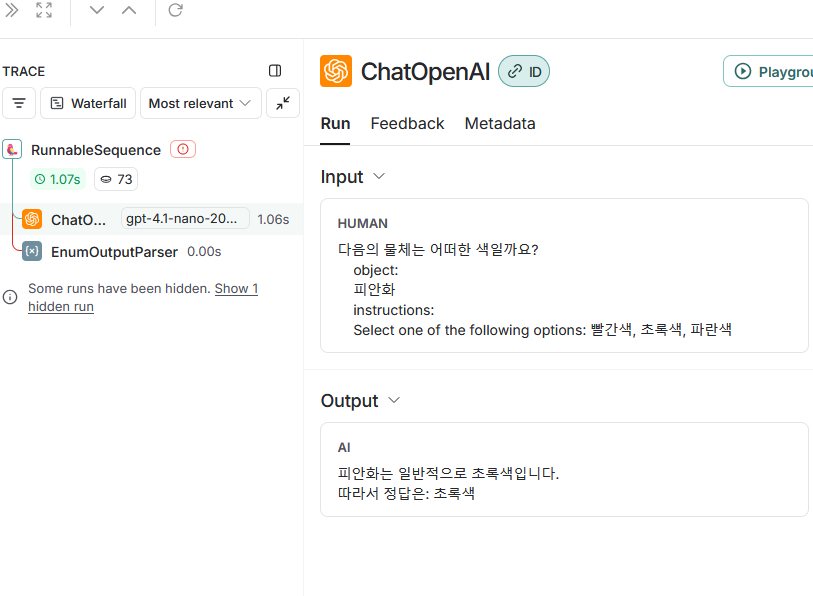

In [188]:
Image(r"C:\Users\roaco\OneDrive\사진\스크린샷\스크린샷 2025-06-16 174614.png")

### 4.1은 그냥 알아서 해줬는데 알잘딱깔센이 작은 모델한텐 엄청 어렵나보다

In [8]:
pdfs = PyMuPDFLoader(r'전동기 고장 데이터 설명자료.pdf')
docs = pdfs.load()

In [26]:
import sys, pymupdf  # import the bindings
doc = pymupdf.open(r"전동기 고장 데이터 설명자료.pdf")  # open document
for page in doc:  # iterate through the pages
    pix = page.get_pixmap()  # render page to an image
    pix.save("images\page-%i.png" % page.number)  # store image as a PNG

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\roaco\AppData\Local\Temp\ipykernel_22804\4036946459.py:5: SyntaxWarning: invalid escape sequence '\p'
  pix.save("images\page-%i.png" % page.number)  # store image as a PNG


In [9]:

text_splits = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)
split_docs = text_splits.split_documents(docs)

In [10]:

embeddings = OpenAIEmbeddings()
vectordb= FAISS.from_documents(documents = split_docs, embedding = embeddings)
retriever = vectordb.as_retriever()


In [6]:
res_schemas = responese_schemas = [
    ResponseSchema(name='answer',description='사용자 질문에 대한 답변'),
    ResponseSchema(
        name = 'source',
        description= '사용자 질문에 답하기 위해 사용한 ''문서의 페이지 번호'' 를 포함해야합니다. '

    ),

]

oparser = StructuredOutputParser.from_response_schemas(responese_schemas)


In [7]:
oparser.get_format_instructions()

'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"answer": string  // 사용자 질문에 대한 답변\n\t"source": string  // 사용자 질문에 답하기 위해 사용한 문서의 페이지 번호 를 포함해야합니다. \n}\n```'

In [12]:

pt = PromptTemplate(
    template= '''
        #Persona:
        당신은 전동기 모터 고장 탐지의 전문가 {name}입니다.
        #Rules:
        context를 참고하여서 format에 맞게 question에 답해주세요,

        #format:
        {format}
        
        #context:        
        {context}
        
        #question:
        {question} 
        
        ''',
    input_variables=['question','name'],
    partial_variables={'format':oparser.get_format_instructions(),'name':'LANI'},
)

pt


PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={'format': 'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"answer": string  // 사용자 질문에 대한 답변\n\t"source": string  // 사용자 질문에 답하기 위해 사용한 문서의 페이지 번호 를 포함해야합니다. \n}\n```', 'name': 'LANI'}, template='\n        #Persona:\n        당신은 전동기 모터 고장 탐지의 전문가 {name}입니다.\n        #Rules:\n        context를 참고하여서 format에 맞게 question에 답해주세요, \n        #format:\n        {format}\n        #context:        \n        {context}\n        #question:\n        {question} \n        ')

In [13]:
model = set_model()

chain = {'context':retriever, 'question':RunnablePassthrough() }| pt| model


In [14]:
chain

{
  context: VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001F388D0DC40>, search_kwargs={}),
  question: RunnablePassthrough()
}
| PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={'format': 'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"answer": string  // 사용자 질문에 대한 답변\n\t"source": string  // 사용자 질문에 답하기 위해 사용한 문서의 페이지 번호 를 포함해야합니다. \n}\n```', 'name': 'LANI'}, template='\n        #Persona:\n        당신은 전동기 모터 고장 탐지의 전문가 {name}입니다.\n        #Rules:\n        context를 참고하여서 format에 맞게 question에 답해주세요, \n        #format:\n        {format}\n        #context:        \n        {context}\n        #question:\n        {question} \n        ')
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F388E535F0>, async_client=<

In [15]:
answer = chain.invoke('축굽힘 고장 유형이란 무엇인가요?')


In [16]:
answer

AIMessage(content='```json\n{\n\t"answer": "축굽힘 고장 유형은 축이 휘거나 휘어진 상태를 의미하며, 이로 인해 전동기의 성능 저하 또는 손상이 발생할 수 있습니다. 축이 휘면 기계적 균형이 깨지고, 진동이 증가하며, 베어링 및 기타 부품에 과부하가 걸릴 수 있습니다.",\n\t"source": "페이지 5"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 1417, 'total_tokens': 1514, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BjJUgY9amQri74Q9Vw2qTAkvO1OGY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a5c61bbe-e9c8-4d5e-80f6-b5faea96ae9c-0', usage_metadata={'input_tokens': 1417, 'output_tokens': 97, 'total_tokens': 1514, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
answer.content

'```json\n{\n\t"answer": "축굽힘 고장 유형은 축이 휘거나 휘어진 상태를 의미하며, 이로 인해 전동기의 성능 저하 또는 손상이 발생할 수 있습니다. 축이 휘면 기계적 균형이 깨지고, 진동이 증가하며, 베어링 및 기타 부품에 과부하가 걸릴 수 있습니다.",\n\t"source": "페이지 5"\n}\n```'

In [18]:
datas = answer.content

type(datas)

str

In [24]:
pages = int(datas.split('페이지')[1].split('"')[0])
pages

5